In [1]:
import pandas as pd
import numpy as np
import vegas
import sys
import os
sys.path.insert(0, "/Users/rocconoe/local/lib/python3.9/site-packages")
import lhapdf


from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
lhapdf.pathsPrepend("/home/sam/miniconda3/pkgs/share/LHAPDF")

> # Momentum distribution:

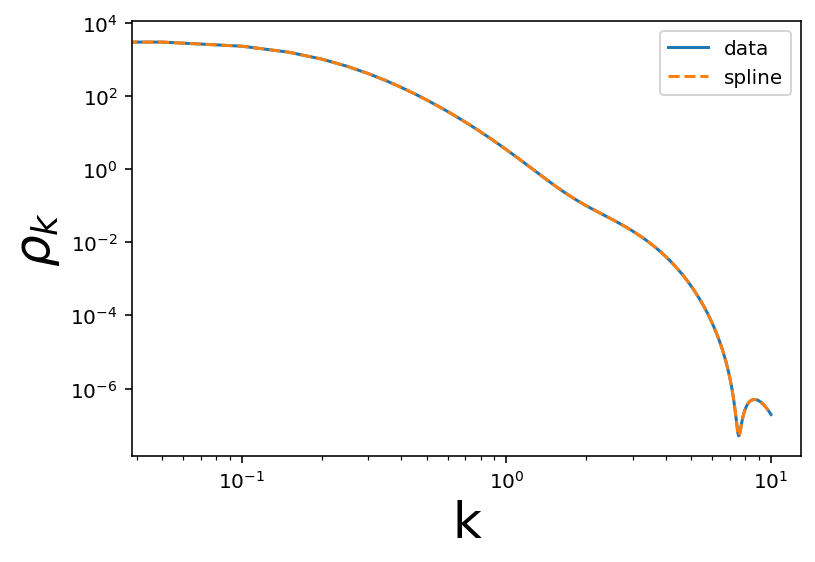

In [3]:
momentum = pd.read_csv('nk_deut.dat', sep='\s+', names=['k','rs','rd','rk'], dtype=np.float64,skiprows=2)
"""Plot the momentum distribution."""
plt.figure(figsize=(6,4));plt.rc('axes', labelsize=25, titlesize=30);plt.plot(momentum['k'],momentum['rk'],label='data');
ps = interp1d(momentum['k'],momentum['rk'], kind='cubic');xnew = np.linspace(0, 10, 200);plt.plot(xnew, ps(xnew),'--',label='spline')
plt.xscale('log');plt.yscale('log');plt.xlabel('k');plt.ylabel(r'$\rho_k$');plt.legend();plt.show()

In [4]:
"""Spline object ps() now interpolates data points."""
print(ps(1))
"""We want to convert from fermi to GeV:"""
def psg(pprime):
    hbarc = 197.32 * 1e3 ; p = pprime/hbarc
    return ps(p)*hbarc**3 # answer in GeV.
print(psg(600))

3.3715
2.468933332840091e+19


In [5]:
"""Normalization check (dk=0.05 by default):"""
pf = (4*np.pi)/pow(2*np.pi,3) ; norm = 0 ; dk = 0.05
for ik,k in enumerate(momentum['k']):
    norm += pow(k,2)*dk*momentum['rk'][ik]
print('The normalized momentum distribution roughly equates to {n:.3f}'.format(n=norm*pf))

The normalized momentum distribution roughly equates to 1.000


> # Function & Class Definitions:

# F(self.pdf, self.E, xn, self.q2)

In [6]:
class PDF:
    """ 
    Class to store the PDF, so it is not constantly re-initialized (should be much quicker)
    """
    def __init__(self, name, set_id):
        self.pdf = lhapdf.mkPDF(name, set_id)
        self.quarks = {'d': 1, 'u': 2, 's': 3, 'c': 4, 'b': 5,
                       'db': -1, 'ub': -2, 'sb': -3, 'cb': -4, 'bb': -5}
        
#     def __call__(self, i, xs, q2, E):
#         if isinstance(i, str):
#             i = self.quarks[i]
#         xfx = np.zeros([len(xs), len(q2)])
#         for ix, x in enumerate(xs):
#             for iq2, q2 in enumerate(q2):
#                 q           = np.sqrt(q2)
#                 xfx[ix, iq2] = self.pdf.xfxQ(i, x, q)
#         return xfx
    def __call__(self, i, xs, q2, E):
        if isinstance(i, str):
            i = self.quarks[i]
        q   = np.sqrt(q2)
        xfx = self.pdf.xfxQ(i, xs, q)
        return xfx

In [7]:
def F2_ep(pdf, E, xs, q2):
    """
    electron-proton scattering F2 expression. (7.4.56)
    """
    series = (4/9)*(pdf("u",xs,q2,E) + pdf("ub",xs,q2,E)) +\
             (1/9)*(pdf("d",xs,q2,E) + pdf("db",xs,q2,E)) +\
             (1/9)*(pdf("s",xs,q2,E) + pdf("sb",xs,q2,E))
    return series

In [8]:
def F2_en(pdf, E, xs, q2):
    """
    electron-neutron scattering F2 expression. (7.4.57)
    """
    series = (4/9)*(pdf("d",xs,q2,E) + pdf("db",xs,q2,E)) +\
             (1/9)*(pdf("u",xs,q2,E) + pdf("ub",xs,q2,E)) +\
             (1/9)*(pdf("s",xs,q2,E) + pdf("sb",xs,q2,E))
    return series

In [9]:
def F1_ep(pdf, E, xs, q2):
    """
    Quiggs Eq. (7.4.52), electron-proton case.
    """
    f1  = F2_ep(pdf,E,xs,q2)
    f1 *= (1/(2*xs))
    return f1

In [10]:
def F1_en(pdf, E, xs, q2):
    """
    electron-neutron case: very similar to F1_ep() function.
    """
    f1  = F2_en(pdf,E,xs,q2)
    f1 *= (1/(2*xs))
    return f1

In [11]:
a         = 1/137    # fine structure constant.
prefactor = 4*np.pi*(a**2)
m_p       = 0.938    # mass of proton in GeV.
m_n       = 0.939    # mass of neutron in GeV.

VEGAS.
do the integral in spherical.
energy goes like the modulus of p.

> # Messing with Deuteron:

In [12]:
M_A = m_p + m_n # entire deuteron nucleus mass.

In [13]:
def ξ(nucleon_mass):
    return nucleon_mass*(M_A)/(2*np.pi)**3

In [14]:
def E_p(p,nucleon_mass):
    return np.sqrt(pow(p,2)+pow(nucleon_mass,2))

> # Vegas integration:

In [15]:
"""Testing p integral seen in t2 of _contribution()."""
def f(p):
    return p**4 * (ps(p)/E_p(p,m_p))
integral = vegas.Integrator([[min(momentum['k']), max(momentum['k'])]])
result = integral(f, nitn=20, neval=10000)
print(result.summary())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   5.44916(85)     5.44916(85)         0.00     1.00
  2   5.44988(24)     5.44983(23)         0.68     0.41
  3   5.44947(18)     5.44961(14)         1.10     0.33
  4   5.44967(16)     5.44964(11)         0.75     0.52
  5   5.44976(15)     5.449679(85)        0.68     0.61
  6   5.44971(15)     5.449686(74)        0.55     0.74
  7   5.44989(15)     5.449726(66)        0.71     0.64
  8   5.44964(15)     5.449712(61)        0.64     0.72
  9   5.44943(16)     5.449677(57)        0.90     0.51
 10   5.44985(17)     5.449695(54)        0.91     0.51
 11   5.44955(19)     5.449684(51)        0.87     0.56
 12   5.44999(20)     5.449704(50)        1.00     0.44
 13   5.44948(20)     5.449691(48)        1.02     0.43
 14   5.44950(20)     5.449680(47)        1.01     0.44
 15   5.44963(23)     5.449678(46)        0.94     0.52
 16   5.44948(23)     5.449670(45)        0.92  

In [20]:
class deut_DIS:
    def __init__(self, q2, pdf, E, xa_bins):
        self.xa_bins = xa_bins
        self.pdf = PDF(pdf, 0)
        self.q2  = q2
        self.E   = E
        
    """This can be greatly simplified if we assume m_p ~ m_n"""
    def f2A(self, x):
        p          = x[0]
        costh      = x[1]
        self.xa    = x[2]
        sinth = np.sqrt(1-costh**2)
        η     = 2*M_A*self.xa

        dI = np.zeros_like(self.xa_bins)
        
        """proton contribution:"""
        denom = 2*(E_p(p,m_p)*self.q2/η - p*costh*np.sqrt(self.q2*(η**2+self.q2)/η**2))
        xn    = self.q2/denom
        if xn < 0 or xn > 1:
            return {'I':0, 'dI':dI}
        else:
            Λ  = (F2_ep(self.pdf, self.E, xn, self.q2)/(m_p**2))
        
            t1 = psg(p)*m_p/E_p(p,m_p)
            t2 = η**2/(self.q2+η**2)*0.5*p**2*sinth**2 * Λ
            t3 = (self.q2*η**4/((self.q2+η**2)**2)) * Λ * (E_p(p,m_p) + self.q2/(2*η*xn))
            pc = (t1*(t2+t3))
            
        """neutron contribution:"""
        denom = 2*(E_p(p,m_n)*self.q2/η - p*costh*np.sqrt(self.q2*(η**2+self.q2)/η**2))
        xn    = self.q2/denom
        if xn < 0 or xn > 1:
            return {'I':0, 'dI':dI}
        else:
            Λ  = (F2_ep(self.pdf, self.E, xn, self.q2)/(m_n**2))
        
            t1 = psg(p)*m_n/E_p(p,m_n)
            t2 = η**2/(self.q2+η**2)*0.5*p**2*sinth**2 * Λ
            t3 = (self.q2*η**4/((self.q2+η**2)**2)) * Λ * (E_p(p,m_n) + self.q2/(2*η*xn))
            nc = (t1*(t2+t3))
    
        I = 1/(2*np.pi)**2 * p**2 * (pc + nc)
        j = np.searchsorted(self.xa_bins, self.xa)
        dI[j] = I
        
        return {'I':I, 'dI':dI}
    
    """Same here."""
    def f1A(self, x):
        p          = x[0]
        costh      = x[1]
        self.xa    = x[2]
        sinth = np.sqrt(1-costh**2)
        η     = 2*M_A*self.xa
        omega = self.q2**2/(η)

        dI = np.zeros_like(self.xa_bins)
        
        """proton contribution:"""
        denom = 2*(E_p(p,m_p)*self.q2/η - p*costh*np.sqrt(self.q2*(η**2+self.q2)/η**2))
        xn    = self.q2/denom
        if xn < 0 or xn > 1:
            return {'I':0, 'dI':dI}
        else:
            t1 = p**2*(psg(p)/E_p(p,m_p))
            t2 = F1_ep(self.pdf, self.E, xn, self.q2)
            t3 = p**2*t1
            t4 = F2_ep(self.pdf, self.E, xn, self.q2)
            pc = ξ(m_p)*2*np.pi * (t1*t2*(1/m_p) + (1/(2*omega*m_p))*t3*t4*sinth**2)
        
        """neutron contribution:""" # we should only do this once (m_p ~ m_n)
        denom = 2*(E_p(p,m_n)*self.q2/η - p*costh*np.sqrt(self.q2*(η**2+self.q2)/η**2))
        xn    = self.q2/denom        
        if xn < 0 or xn > 1:
            return {'I':0, 'dI':dI}
        else:
            t1 = p**2*(psg(p)/E_p(p,m_n))
            t2 = F1_en(self.pdf, self.E, xn, self.q2)
            t3 = p**2*t1
            t4 = F2_en(self.pdf, self.E, xn, self.q2)
            nc = ξ(m_n)*2*np.pi * (t1*t2*(1/m_n) + (1/(2*omega*m_n))*t3*t4*sinth**2)
        
        I = (pc + nc)
        j = np.searchsorted(self.xa_bins, self.xa)
        dI[j] = I
        
        return {'I':I, 'dI':dI}

In [21]:
%%time
"""f1A testing."""
deut = deut_DIS(q2=2,pdf='cteq66',E=15,xa_bins=np.logspace(-5,0,100))

integral = vegas.Integrator([[0,0.6],[-1,1],[0,1]]) # p in GeV, theta, xa.
result = integral(deut.f1A, nitn=10, neval=1000)
print(result.summary())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   4.5(4.2)e+18    4.5(4.2)e+18        0.00     1.00
  2   2.77(38)e+17    2.66(35)e+17        1.41     0.00
  3   3.02(28)e+17    2.08(13)e+17        1.93     0.00
  4   1.59(93)e+18    1.999(47)e+17       2.70     0.00
  5   7.7(1.9)e+17    2.144(28)e+17       3.43     0.00
  6   8.8(7.7)e+18    2.248(24)e+17       5.56     0.00
  7   1.18(25)e+18    2.142(21)e+17       7.07     0.00
  8   1.31(17)e+18    1.777(14)e+17      10.17     0.00
  9   1.58(13)e+18    1.763(13)e+17      11.19     0.00
 10   6.0(2.2)e+18    1.757(13)e+17      11.48     0.00

CPU times: user 6.36 s, sys: 156 ms, total: 6.52 s
Wall time: 5.11 s


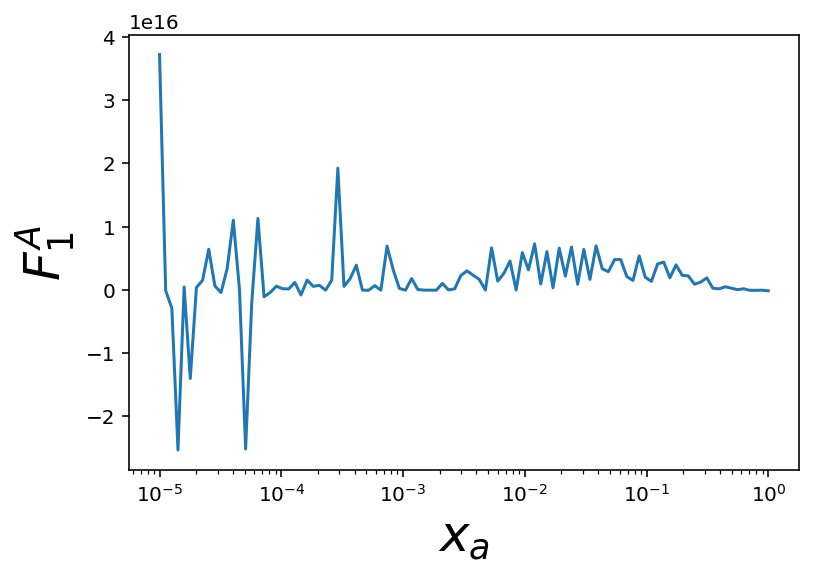

In [22]:
plt.plot(deut.xa_bins, [x.mean for x in result['dI']])
plt.xscale('log')
plt.xlabel(r'$x_{a}$')
plt.ylabel(r'$F_{1}^{A}$')
plt.show()

In [23]:
%%time
"""f2A testing."""
result = integral(deut.f2A, nitn=10, neval=1000)
print(result.summary())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   8.4(1.1)e+15    8.4(1.1)e+15        0.00     1.00
  2   9.22(47)e+15    7.05(27)e+15        2.10     0.00
  3   9.08(21)e+15    7.44(15)e+15        2.84     0.00
  4   9.65(21)e+15    7.74(10)e+15        3.27     0.00
  5   9.58(16)e+15    8.060(82)e+15       3.89     0.00
  6   9.40(12)e+15    8.205(62)e+15       4.29     0.00
  7   9.63(11)e+15    8.431(52)e+15       4.55     0.00
  8   9.548(96)e+15   8.616(44)e+15       4.57     0.00
  9   9.429(93)e+15   8.690(39)e+15       4.60     0.00
 10   9.386(83)e+15   8.768(35)e+15       4.60     0.00

CPU times: user 5.14 s, sys: 109 ms, total: 5.25 s
Wall time: 4.1 s


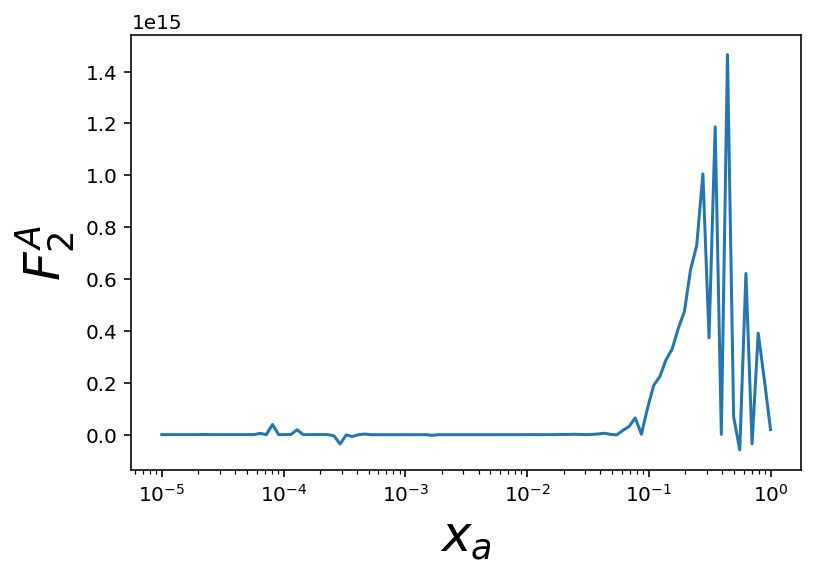

In [24]:
plt.plot(deut.xa_bins, [x.mean for x in result['dI']])
plt.xscale('log')
plt.xlabel(r'$x_{a}$')
plt.ylabel(r'$F_{2}^{A}$')
plt.show()